# ASL Classification for Augmented Reality Interactive Learning
Author:  
Alexander Claudino Daffara  
https://medium.com/@alexanderdaffara  
https://www.linkedin.com/in/alexanderdaffara/

## Business Problem
In 2017, researchers at Georgia Tech university released the app PopSign! Using dynamic image classification game where users use ASL signs to control a cannon and pop the bubbles. The app tackles the rich idea of gamifying the learning process for learning ASL, targeting parents and relatives of deaf individuals. Unfortunately, there hasn't been enough development with the concept in comparison to the leaps in computer vision technology we've seen in AI research.  

Six years later, Google releases their 'Isolated Sign Language Recognition' Dataset as part of a Kaggle competition. So I will help enhace PopSign's educational games.

## Goals
 - Accurately classify ASL sign from video footage
 - Optimize lightweighted-ness of our model for scalability and ease of use for a phone app
 - Optimize *recall* for more common words
 - Demonstrate the proof of concept for fututre testing and Deployment

## Data Understanding
Google's Isolated Sign Language Recognition Dataset (54.43 GB):
 - 94k short clips (about 7-40 frames) of isolated ASL signs
 - 250 unique signs represented
 - 21 unique signers

The video footage has been preprocessed through MediaPipe's Holistic Solution model, mapping points (landmarks) on the face, hands and body as x-y-z coordinates in the frame.
Every clip comes in a .parquet file, where each row contains:
 - *row_id* : unique id string combining the other features
 - *frame* : frame number
 - *type* : the body part this landmark is part of (face, pose, right_hand, left_hand)
 - *landmark_index* : id of the landmark within it's *type*
 - *x*, *y*, *z* : coordinate positions normalized [ 0,1 ], although the Holistic model has not been optimized to accurately map depth *z*

Finally, for each frame we consistently have:
 - Face landmarks: 468 rows
 - Pose landmarks: 33 rows
 - Right hand landmarks: 21 rows
 - Left hand landmarks: 21 rows


### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, log_loss, classification_report, 
                             roc_auc_score, ConfusionMatrixDisplay, 
                             confusion_matrix)
from imblearn.over_sampling import SMOTE

sklearn.set_config(display='diagram')
%matplotlib inline

# Exploring one Sign example - Hungry
Lets take a look at what the landmark positions and change vectors look like for a single file

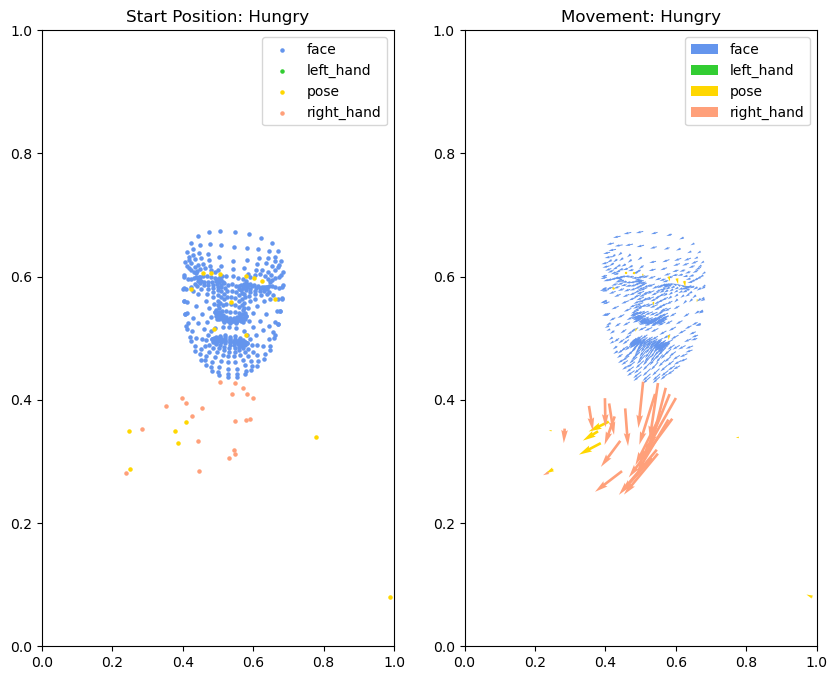

In [12]:
# load in parquet file
df = pd.read_parquet('data/1005995721.parquet')
# invert y column to vizualize upright
df['y'] = 1-df['y']

# set up axes and iterable titles and colors
fig, axes = plt.subplots(ncols=2,figsize=(10,8))
colors=['cornflowerblue','limegreen','gold','lightsalmon']
titles = ['Start Position: Hungry', 'Movement: Hungry']

# dataframes containing info from first and last frame of video
first_frame = df.loc[df.frame==df.frame.min()]
last_frame = df.loc[df.frame==df.frame.max()]

for i, type in enumerate(list(df.type.unique())):
    # select only landmarks of type == type 
    # (from [face,right_hand,left_hand,pose])
    start = first_frame.loc[df.type == type]
    end = last_frame.loc[df.type == type]
    # Vector origin location
    X = start['x'].to_list()
    Y = start['y'].to_list()
    
    # Directional vectors
    U = np.array(end['x'].to_list()) - np.array(X)
    V = np.array(end['y'].to_list()) - np.array(Y)

    # Creating plot
    axes[0].scatter(X,Y, c=colors[i], label=type,s=5)
    axes[1].quiver(X, Y, U, V, 
                   color=colors[i], 
                   units='xy', 
                   scale=1, 
                   headwidth=2.5, 
                   label=type)

for i, ax in enumerate(axes):
    # x-lim and y-lim
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_title(titles[i])
    ax.legend()
plt.show()

# Load Data and Train-Test-Split

The Full dataset was loaded in with AquiringData.ipynb  
Columns:
 - sign : 87 unique signs
 - *type* (face: 468* 4 columns, left_hand: 21* 4 columns, right_hand: 21* 4 columns, pose: 31*4 columns)
    - px_i_type : starting x position of the ith landmark, from landmarks in *type*
    - py_i_type : starting y position of the ith landmark, from landmarks in *type*
    - dx_i_type : total change in x position of the ith landmark, from landmarks in *type*
    - dy_i_type : total change in y position of the ith landmark, from landmarks in *type*

In [13]:
# Load Meta Data
meta_data = pd.read_csv('data/train.csv')

# Load Data
signs = pd.read_csv('data/all_targets.csv',index_col=0)['0'].to_list()
signs_5 = ['hungry','stay','drink','dad','sad']
dataset_5_signs = pd.read_csv('data/dataset_hungry_stay_drink_dad_sad.csv', 
                              index_col=0)
dataset = pd.concat((dataset_5_signs,
                     pd.read_csv('data/dataset_round2_155.csv',
                                 index_col=0)), 
                    axis=0)
# Load sign name to int mapping
with open('data/sign_to_prediction_index_map.json') as f:
    sign_map = json.load(f)

# fix columns name ordering from data preprocessing
col_names_fixed = pd.read_csv('data/col_names_fixed.csv', 
                              index_col=0)['0'].values
dataset_5_signs.rename(
    columns={old:new for old, new in zip(dataset_5_signs.columns,
                                         col_names_fixed)}, 
    inplace=True)
dataset.rename(
    columns={old:new for old, new in zip(dataset_5_signs.columns,
                                         col_names_fixed)}, 
    inplace=True)

# Train Test Split 5 signs
X = dataset_5_signs.drop(columns='sign')
y = dataset_5_signs['sign'].map({sign:i for i, sign in enumerate(signs_5)})
X_train_5_signs, X_test_5_signs, y_train_5_signs, y_test_5_signs = \
    train_test_split(X, y, test_size=.25, stratify=y, random_state=42)
print('Small Dataset (5 signs), train test shapes:')
print(X_train_5_signs.shape, 
      X_test_5_signs.shape, 
      y_train_5_signs.shape, 
      y_test_5_signs.shape)

# Train Test Split 87 signs
X = dataset.drop(columns='sign')
y = dataset['sign'].map({sign:i for i, sign in enumerate(signs)})
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.25, 
                                                    stratify=y, 
                                                    random_state=42)
print('Full Dataset (5 signs), train test shapes:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Small Dataset (5 signs), train test shapes:
(1447, 2172) (483, 2172) (1447,) (483,)
Full Dataset (5 signs), train test shapes:
(45390, 2172) (15130, 2172) (45390,) (15130,)


In [10]:
# show dataset format and shape
display(dataset.head())
dataset.shape

,px_0_face,py_0_face,dx_0_face,dy_0_face,px_1_face,py_1_face,dx_1_face,dy_1_face,px_2_face,py_2_face,...,dy_30_pose,px_31_pose,py_31_pose,dx_31_pose,dy_31_pose,px_32_pose,py_32_pose,dx_32_pose,dy_32_pose,sign
0,0.144412,0.770001,-0.036422,0.060955,0.220252,0.751034,-0.007117,0.059470,0.294891,0.766529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hungry
1,0.228887,0.870846,0.149825,0.046881,0.217067,0.780410,0.173444,0.069344,0.283111,0.704707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hungry
2,0.219266,0.694923,-0.047326,0.136267,0.246657,0.630376,-0.000493,0.144555,0.315621,0.584842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hungry
3,0.265351,0.609593,-0.113243,0.169336,0.300004,0.556525,-0.051936,0.175018,0.358254,0.529226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hungry
4,0.192178,0.910085,-0.109875,0.009503,0.231285,0.847868,-0.097434,0.014697,0.305320,0.801218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hungry


(60520, 2173)

## Vizualizing Target Imbalance

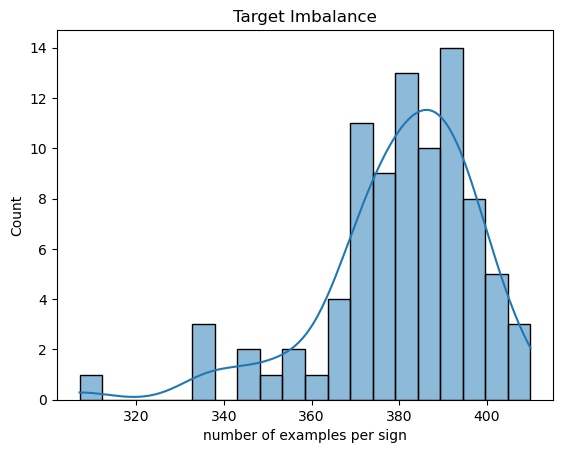

In [ ]:
# hisplot target column
sns.histplot(
    meta_data.loc[[sign in signs for sign in meta_data.sign]].sign.value_counts(), 
    kde=True, 
    bins=20)
plt.xlabel('number of examples per sign')
plt.title('Target Imbalance')
plt.show()

# Baseline model

#### Logistic Regression 5 signs

In [ ]:
# Set up pipeline
lr_small_model = Pipeline(steps=[('model', 
                                  LogisticRegression(max_iter=1000))])
# fit with small dataset (5 total signs/targets)
lr_small_model.fit(X_train_5_signs, y_train_5_signs)
# show metrics
lr_small_pred = lr_small_model.predict(X_test_5_signs)
lr_small_report = classification_report(y_test_5_signs, 
                                        lr_small_pred,
                                        target_names=signs_5, 
                                        output_dict=True)
lr_small_metrics_df = pd.DataFrame(lr_small_report).transpose()
print('Mean Accuracy: ',lr_small_metrics_df['support']['accuracy'])
print('Mean Precision:',lr_small_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',lr_small_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',lr_small_metrics_df['f1-score']['macro avg'])
lr_small_metrics_df

Mean Accuracy:  0.8322981366459627
Mean Precision: 0.8341454272863569
Mean Recall:    0.8330015616548971
Mean f1-score:  0.8323935003390449


,precision,recall,f1-score,support
hungry,0.833333,0.833333,0.833333,96.000000
stay,0.788462,0.872340,0.828283,94.000000
drink,0.804348,0.740000,0.770833,100.000000
dad,0.908046,0.831579,0.868132,95.000000
sad,0.836538,0.887755,0.861386,98.000000
accuracy,0.832298,0.832298,0.832298,0.832298
macro avg,0.834145,0.833002,0.832394,483.000000
weighted avg,0.833945,0.832298,0.831947,483.000000


# Model Iterations

## Model Iteration 1 - Logistic Regression

#### Hyperparameter tuning with 87 signs

In [21]:
# set up pipeline
lr_pipe = Pipeline(steps=[('model', LogisticRegression())])

# parameters to gridsearch
param_grid = {'model__C':[1e-1,1],
              'model__max_iter':[500,1000],
              'model__class_weight':['balanced',None],
              'model__tol':[1e-4]}
# declare and run gridsearch
gs_lr_pipe = GridSearchCV(estimator=lr_pipe, param_grid=param_grid)
gs_lr_pipe.fit(X_train,y_train)

In [22]:
# save best linear regression model
lr_best_model = gs_lr_pipe.best_estimator_
display(lr_best_model)
# show metrics
lr_pred = lr_best_model.predict(X_test)
lr_report = classification_report(y_test, 
                                  lr_pred, 
                                  target_names=signs, 
                                  output_dict=True)
lr_metrics_df = pd.DataFrame(lr_report).transpose()
print('Mean Accuracy: ',lr_metrics_df['support']['accuracy'])
print('Mean Precision:',lr_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',lr_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',lr_metrics_df['f1-score']['macro avg'])
lr_metrics_df

/Users/alexanderdaffara/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('model', LogisticRegression(max_iter=1000))])

Mean Accuracy:  0.4922009253139458
Mean Precision: 0.5277185706225866
Mean Recall:    0.43162404117831177
Mean f1-score:  0.44718441676115345


,precision,recall,f1-score,support
pig,0.600000,0.358696,0.448980,92.000000
elephant,0.311628,0.350785,0.330049,191.000000
mad,0.406780,0.408163,0.407470,294.000000
finger,0.409836,0.352113,0.378788,284.000000
green,0.475765,0.781971,0.591594,477.000000
...,...,...,...,...
dad,0.875000,0.819149,0.846154,94.000000
sad,0.868132,0.806122,0.835979,98.000000
accuracy,0.492201,0.492201,0.492201,0.492201
macro avg,0.527719,0.431624,0.447184,15130.000000


## Model iteration 2 - Random Forest

#### Hyperparameter tuning with 87 signs

In [58]:
# set up pipeline
rf_pipe = Pipeline(steps=[('model', 
                           RandomForestClassifier(random_state=42))])

# parameters to gridsearch
param_grid = {'model__max_depth':[2,3,4,10],
              'model__n_estimators':[500,1000],
              'model__class_weight':['balanced',
                                     'balanced_subsample',
                                      None],
              'model__tol':[1e-4]}
# declare and run gridsearch
gs_rf_pipe = GridSearchCV(estimator=rf_pipe, param_grid=param_grid)
gs_rf_pipe.fit(X_train,y_train)

In [60]:
# save best random forest model
rf_best_model = gs_rf_pipe.best_estimator_
display(rf_best_model)
# show metrics
rf_pred = rf_best_model.predict(X_test)
rf_report = classification_report(y_test, 
                                  rf_pred, 
                                  target_names=signs, 
                                  output_dict=True)
rf_metrics_df = pd.DataFrame(rf_report).transpose()
print('Mean Accuracy: ',rf_metrics_df['support']['accuracy'])
print('Mean Precision:',rf_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',rf_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',rf_metrics_df['f1-score']['macro avg'])
rf_metrics_df

Pipeline(steps=[('model', RandomForestClassifier(random_state=42))])

Mean Accuracy:  0.7476536682088566
Mean Precision: 0.6909030004854534
Mean Recall:    0.5984600752722209
Mean f1-score:  0.5980725269969054


,precision,recall,f1-score,support
pig,0.485714,0.369565,0.419753,92.000000
elephant,0.776744,0.874346,0.822660,191.000000
mad,0.801136,0.959184,0.873065,294.000000
finger,0.725594,0.968310,0.829563,284.000000
green,0.763200,1.000000,0.865699,477.000000
...,...,...,...,...
dad,0.903614,0.797872,0.847458,94.000000
sad,0.793814,0.785714,0.789744,98.000000
accuracy,0.747654,0.747654,0.747654,0.747654
macro avg,0.690903,0.598460,0.598073,15130.000000


## Model Iteration 3 - Histogram XGBoost

#### Hyperparameter tuning with 87 signs

In [26]:
# set up pipeline
hxgb_pipe = Pipeline(steps = [('model', 
                               XGBClassifier(subsample = 1,
                                             tree_method='gpu_hist',
                                             predictor='gpu_predictor',
                                             random_state=42) )])
# parameters to gridsearch
param_grid = {'model__max_depth':[2,3,4,10],
              'model__n_estimators':[100,300,500],
              'model__max_bin':[32,64],
              'model__colsample_bytree':[.8,.9,1]}
# declare and run gridsearch
gs_hxgb_pipe = GridSearchCV(estimator=hxgb_pipe, param_grid=param_grid)
gs_hxgb_pipe.fit(X_train,y_train)
                                 

In [25]:
# save best histXGBoost model
hxgb_best_model = gs_hxgb_pipe.best_estimator_
display(hxgb_best_model)
# show metrics
hxgb_pred = hxgb_best_model.predict(X_test)
hxgb_report = classification_report(y_test, 
                                    hxgb_pred, 
                                    target_names=signs, 
                                    output_dict=True)
hxgb_metrics_df = pd.DataFrame(hxgb_report).transpose()
print('Mean Accuracy: ',hxgb_metrics_df['support']['accuracy'])
print('Mean Precision:',hxgb_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',hxgb_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',hxgb_metrics_df['f1-score']['macro avg'])
hxgb_metrics_df

Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=64,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=4, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob',
                               predictor='gpu_predictor', ...))])

Mean Accuracy:  0.8015862524785194
Mean Precision: 0.7349734200627183
Mean Recall:    0.6845124696429522
Mean f1-score:  0.6952299364721685


,precision,recall,f1-score,support
pig,0.632353,0.467391,0.537500,92.000000
elephant,0.799065,0.895288,0.844444,191.000000
mad,0.850746,0.969388,0.906200,294.000000
finger,0.774648,0.968310,0.860720,284.000000
green,0.889925,1.000000,0.941757,477.000000
...,...,...,...,...
dad,0.827957,0.819149,0.823529,94.000000
sad,0.806452,0.765306,0.785340,98.000000
accuracy,0.801586,0.801586,0.801586,0.801586
macro avg,0.734973,0.684512,0.695230,15130.000000


## Final Model - Histogram XGBoost + SMOTE

In [27]:
X_train_smote, y_train_smote = \
    SMOTE(sampling_strategy='not majority').fit_resample(X_train,y_train)
X_train_smote.shape, y_train_smote.shape

((152685, 2172), (152685,))

#### Hyperparameter tuning with 87 signs

In [30]:
# set up pipeline
hxgb_pipe = Pipeline(steps = [('model', 
                               XGBClassifier(subsample = 1,
                                             tree_method='gpu_hist',
                                             predictor='gpu_predictor',
                                             random_state=42) )])
# parameters to gridsearch
param_grid = {'model__max_depth':[2,3,4,10],
              'model__n_estimators':[100,300,500],
              'model__max_bin':[32,64],
              'model__colsample_bytree':[.8,.9,1]}
# declare and run gridsearch
gs_hxgb_pipe = GridSearchCV(estimator=hxgb_pipe, param_grid=param_grid)
gs_hxgb_pipe.fit(X_train_smote,y_train_smote)

In [32]:
# save best histXGBoost (+SMOTE) model
hxgb_best_model = gs_hxgb_pipe.best_estimator_
display(hxgb_best_model)
# show metrics
hxgb_pred = hxgb_best_model.predict(X_test)
hxgb_report = classification_report(y_test, 
                                    hxgb_pred, 
                                    target_names=signs, 
                                    output_dict=True)
hxgb_metrics_df = pd.DataFrame(hxgb_report).transpose()
print('Mean Accuracy: ',hxgb_metrics_df['support']['accuracy'])
print('Mean Precision:',hxgb_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',hxgb_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',hxgb_metrics_df['f1-score']['macro avg'])
hxgb_metrics_df

Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=64,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=4, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob',
                               predictor='gpu_predictor', ...))])

Mean Accuracy:  0.8606080634500991
Mean Precision: 0.8385839842573934
Mean Recall:    0.8616946671629468
Mean f1-score:  0.8480013603800165


,precision,recall,f1-score,support
pig,0.626506,0.565217,0.594286,92.000000
elephant,0.872727,0.753927,0.808989,191.000000
mad,0.885714,0.843537,0.864111,294.000000
finger,0.905138,0.806338,0.852886,284.000000
green,0.944690,0.895178,0.919268,477.000000
...,...,...,...,...
dad,0.978261,0.957447,0.967742,94.000000
sad,0.989130,0.928571,0.957895,98.000000
accuracy,0.860608,0.860608,0.860608,0.860608
macro avg,0.838584,0.861695,0.848001,15130.000000


# Feature Importance
Although not always significant, I'll save the features that led to the most information gain during training of XGBoost

In [42]:
# get feature importances from model, save to hxgb_feat_imp dataframe
hxgb_feat_imp = pd.DataFrame(hxgb_best_model['model'].feature_importances_, 
                             index=col_names_fixed[:-1], 
                             columns=['importance']).reset_index()
# include info columns
hxgb_feat_imp['type'] = \
    hxgb_feat_imp['index'].map(lambda x: x.split('_')[-1])
hxgb_feat_imp['kinematic'] = \
    hxgb_feat_imp['index'].map(lambda x: x.split('_')[0][0])
hxgb_feat_imp['landmark'] = \
    hxgb_feat_imp['index'].map(lambda x: int(x.split('_')[1]))
# rename feature name column to id
hxgb_feat_imp.rename(columns={'index':'id'}, inplace=True)
# sort by highest importance
top_imp = hxgb_feat_imp.sort_values(by='importance', 
                                    ascending=False).head(50)
top_imp.head()

,id,importance,type,kinematic,landmark
8,px_2_left_hand,0.006024,hand,p,2
1201,py_246_face,0.005638,face,p,246
560,px_86_face,0.005052,face,p,86
2133,py_11_right_hand,0.004949,hand,p,11
1512,px_324_face,0.004600,face,p,324


# Landmark analysis
"Dad" and "Airplane" have very similar signs, although the model scored exceptionally well with those targets.
This if useful for PopSign! to show the user the difference between the two signs.

Lets look now at a visualization that averages all the test results that were predicted as "Dad" and "Airplane", and highlight the points and vectors that were most important to our model.

In [ ]:
# show final model metrics for dad and airplane
hxgb_metrics_df.loc[['dad','airplane']]

,precision,recall,f1-score,support
dad,0.978261,0.957447,0.967742,94.0
airplane,0.931655,0.877966,0.904014,295.0


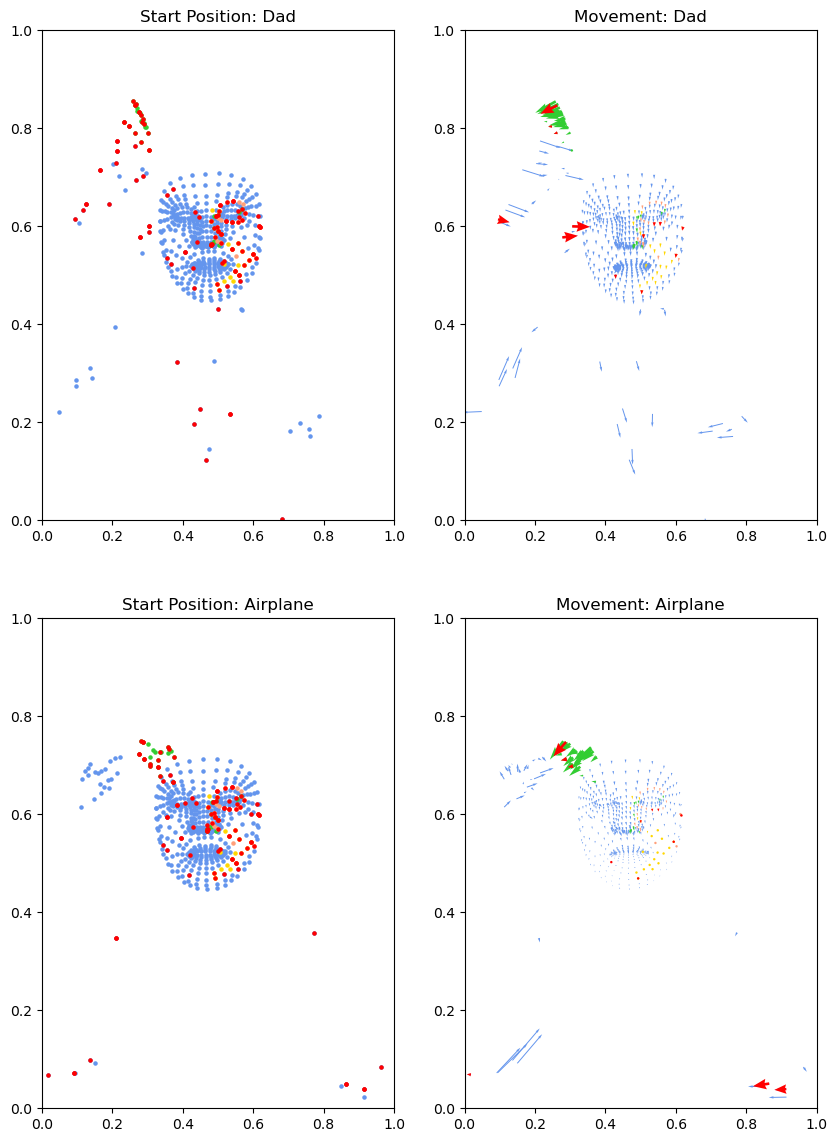

In [54]:
# query list for signs to vizualize
sign_queries = ['dad','airplane']
# convert to integer ids used by model for the targets
sign_query_ids = \
    [signs.index(sign_query) for sign_query in sign_queries]
# make a dataframe from y_test set, 
# we will subset it with our sign_queries
yt_df = pd.DataFrame(y_test)

# set up axes, colors and titles
fig, axes = plt.subplots(ncols=2,
                         nrows=len(sign_queries),
                         figsize=(10,14))
colors=['cornflowerblue','gold','limegreen','lightsalmon']
titles = [['Start Position: Dad', 'Movement: Dad'],
          ['Start Position: Airplane', 'Movement: Airplane']]

# iterate through sign_queries 
for sign_query_iter, sign_query_id in enumerate(sign_query_ids):
    # subset of test set labelled dad and airplane
    sign_query_res = \
        X_test.loc[yt_df.loc[yt_df.sign==sign_query_id].index]

    ax_id = {'p':0,'d':1}

    cols = list(sign_query_res.columns)
    # boolean lists to select columns by their attributes from sign_query_res
    px_keep = [col.split('_')[0] != 'px' for col in cols]
    dx_keep = [col.split('_')[0] != 'dx' for col in cols]
    py_keep = [col.split('_')[0] != 'py' for col in cols]
    dy_keep = [col.split('_')[0] != 'dy' for col in cols]
    face_keep = [col.split('_')[-1] != 'face' for col in cols]
    pose_keep = [col.split('_')[-1] != 'pose' for col in cols]
    rh_keep = [col.split('_')[-2] != 'right' for col in cols]
    lh_keep = [col.split('_')[-2] != 'left' for col in cols]

    types = [face_keep,lh_keep,pose_keep,rh_keep]
    type_name = ['face','left_hand','pose','right_hand']

    # iterate through types
    for type_i, type_keep in enumerate(types):
        # Vector origin location
        X = sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if px_keep[i] or type_keep[i]]).mean().values
        Y = 1-sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if py_keep[i] or type_keep[i]]).mean().values
        
        # Directional vectors
        U = sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if dx_keep[i] or type_keep[i]]).mean().values
        V = -sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if dy_keep[i] or type_keep[i]]).mean().values
        # Creating plot
        axes[sign_query_iter][0].scatter(
            X,Y, c=colors[type_i], label=type_name[type_i],s=5)
        axes[sign_query_iter][1].quiver(
            X, Y, U, V, color=colors[type_i], units='xy', scale=.5, 
            headwidth=2.5, label=type_name[type_i])

    # iterate through sorted list of important features
    for idx in top_imp.index:
        feat = top_imp.loc[idx]
        lm_keep = [col.split('_')[1] != str(feat['landmark']) for col in cols]
        X = sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if px_keep[i] or lm_keep[i]]).mean().values
        Y = 1-sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if py_keep[i] or lm_keep[i]]).mean().values
        U = sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if dx_keep[i] or lm_keep[i]]).mean().values
        V = -sign_query_res.drop(
            columns=[cols[i] for i in range(len(cols)) \
                     if dy_keep[i] or lm_keep[i]]).mean().values
        if feat['kinematic'] == 'p':
            axes[sign_query_iter][ax_id[feat['kinematic']]].scatter(
                X,Y,c='red', s=5)
        else:
            axes[sign_query_iter][ax_id[feat['kinematic']]].quiver(
                X, Y, U, V, color='red', units='xy', scale=.5, headwidth=4)

    # limit axes to only show range[0,1] (frame size)
    for i, ax in enumerate(axes[sign_query_iter]):
        # x-lim and y-lim
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        ax.set_title(titles[sign_query_iter][i])
plt.show()

## Conclusions and Future Improvements
 - Scalable: Our final model maintains performance as we increase number of signs to predict.
 - Lightweight: Model is intrinsically faster to train and predict compared to other sophisticated models.
 - Optimized for common words.

As I continue work on this project I would like to explore extracting more information from each video file, and in the case of deployment for production, it would be good to add more signers and ensure the model adapts to new environments the signers find themselves in.

Learn More about MediaPipe's solutions:
https://google.github.io/mediapipe/solutions/holistic.html

Kaggle Competition Link:
https://www.kaggle.com/competitions/asl-signs/overview